In [213]:

import os
OLD_DATAPATH = 'data_old'
DATAPATH = 'data'

In [215]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomBrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = self._create_file_pairs()
        
    def _create_file_pairs(self):
        datasets = ["CamCAN", "HCP", "IXI"]
        pairs = []

        for dataset in datasets:
            t1_dir = os.path.join(self.root_dir, dataset, "T1w_axial_png")
            t2_dir = os.path.join(self.root_dir, dataset, "T2w_axial_png")
            
            # Trova i file presenti in entrambe le cartelle
            t1_files = set(os.listdir(t1_dir))
            t2_files = set(os.listdir(t2_dir))
            common_files = t1_files.intersection(t2_files)

            for fname in common_files:
                t1_path = os.path.join(t1_dir, fname)
                t2_path = os.path.join(t2_dir, fname)
                pairs.append((t1_path, t2_path, dataset))

        return pairs
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        t1_path, t2_path, dataset = self.samples[idx]
        # Carica in bianco e nero
        t1_image = Image.open(t1_path).convert("L")
        t2_image = Image.open(t2_path).convert("L")
        
        if self.transform:
            t1_image = self.transform(t1_image)
            t2_image = self.transform(t2_image)
        
        return {"t1": t1_image, "t2": t2_image, "filename": os.path.basename(t1_path), "dataset": dataset}

# Esempio di utilizzo
from torchvision import transforms

data_transform = transforms.Compose([
    #  transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = CustomBrainDataset(root_dir=OLD_DATAPATH, transform=data_transform)
print(f"Total pairs: {len(dataset)}")





Total pairs: 2192


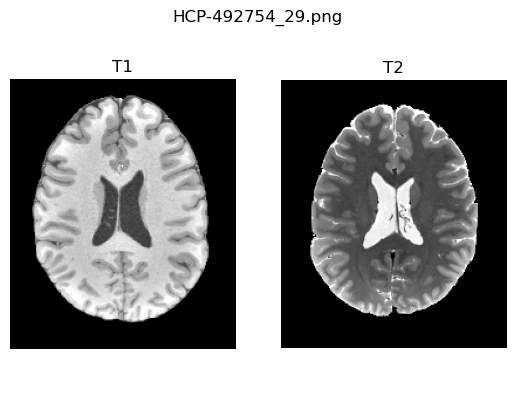

torch.Size([1, 218, 182])
2192


In [227]:
# print one image
import matplotlib.pyplot as plt
import numpy as np
import random 

def imshow(entry):
    plt.title(f'{entry['filename']}')
    plt.axis('off')
    img = entry['t1'] / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.subplot(121)
    plt.title('T1')
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    img = entry['t2'] / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.subplot(122)
    plt.title('T2')
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()
    
entry = dataset[random.randint(0, len(dataset)-1)]

imshow(entry)
print(entry['t1'].shape)
print(len(dataset))


In [159]:
from torchvision.transforms import functional as F

TARGET_SIZE = (218, 182)


def center_crop_fixed(tensor, target_size=TARGET_SIZE):
    _, h, w = tensor.shape
    th, tw = target_size

    # Se l'immagine è più piccola del target, lasciala com'è
    if h <= th and w <= tw:
        return tensor

    # Calcola i margini per il centro
    start_h = (h - th) // 2
    start_w = (w - tw) // 2

    # Esegui il crop (ignora i bordi in eccesso)
    cropped = tensor[:, start_h:start_h + th, start_w:start_w + tw]

    # Verifica che la dimensione sia esattamente quella target
    if cropped.shape[1:] != target_size:
        raise ValueError(
            f"Crop fallito: ottenuto {cropped.shape[1:]}, atteso {target_size}")

    return cropped

In [160]:
import matplotlib.pyplot as plt

def show_images(t1, t2, t2_flipped):
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(t1.squeeze().cpu(), cmap='gray')
    axs[0].set_title('T1')
    axs[1].imshow(t2.squeeze().cpu(), cmap='gray')
    axs[1].set_title('T2 Originale')
    axs[2].imshow(t2_flipped.squeeze().cpu(), cmap='gray')
    axs[2].set_title('T2 Flippato')
    plt.show()


In [ ]:
from torchmetrics.functional import structural_similarity_index_measure as ssim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import tqdm


data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Cartella di output
save_dir = './data'
os.makedirs(os.path.join(save_dir, 't1'), exist_ok=True)
os.makedirs(os.path.join(save_dir, 't2'), exist_ok=True)

count = 0
flipped_in_CC = []
flipped_in_HCP = []
flipped_in_IXI = []
original_in_CC = []
original_in_HCP = []
original_in_IXI = []
resized_in_CC = []
resized_in_HCP = []
resized_in_IXI = []
# Processo di matching
for batch in tqdm.tqdm(data_loader, desc="Elaborazione immagini", unit="batch"):
    if batch['t1'][0].shape[1:] != TARGET_SIZE:
        # print(f"Croppando la t1 di {batch['filename'][0]} da {batch['t1'][0].shape} a {(1, *TARGET_SIZE)}")
        t1 = center_crop_fixed(batch['t1'][0])
        # print(f"Nuove dimensioni: {t1.shape}")
        if '|X|' in batch['filename'][0] :
            resized_in_IXI.append(batch['filename'][0])
        elif 'sub-CC' in batch['filename'][0]:
            resized_in_CC.append(batch['filename'][0])
        elif 'HCP' in batch['filename'][0]:
            resized_in_HCP.append(batch['filename'][0])
    else:
        t1 = batch['t1'][0]
    if batch['t2'][0].shape[1:] != TARGET_SIZE:
        # print(f"Croppando la t2 di {batch['filename'][0]} da {batch['t2'][0].shape} a {(1, *TARGET_SIZE)}")
        t2 = center_crop_fixed(batch['t2'][0])
        # print(f"Nuove dimensioni: {t2.shape}")
        if 'IXI' in batch['filename'][0] :
            resized_in_IXI.append(batch['filename'][0])
        elif 'sub-CC' in batch['filename'][0]:
            resized_in_CC.append(batch['filename'][0])
        elif 'HCP' in batch['filename'][0]:
            resized_in_HCP.append(batch['filename'][0])
    else:
        t2 = batch['t2'][0]
        
    fname = batch['filename'][0]
# HCP-144226_31.png - SSIM originale: 0.4083, specchiato: 0.3265 -> Originale
# Croppando la t2 di HCP-137229_22.png da torch.Size([1, 229, 193]) a (1, 218, 182)
# Nuove dimensioni: torch.Size([1, 218, 182])
# Flip scelto per HCP-137229_22.png con SSIM 0.3765 > 0.4257
    # # Confronto SSIM
    # t1_cv2 = tensor_to_cv2(t1)
    # t2_cv2 = tensor_to_cv2(t2)
    # # Calcola il punteggio di corrispondenza SIFT
    # score_original = match_score_sift(t1_cv2, t2_cv2)
    # # Calcola il punteggio di corrispondenza SIFT per l'immagine specchiata
    # t2_flipped_cv2 = tensor_to_cv2(torch.flip(t2, [2]))
    # score_flipped = match_score_sift(t1_cv2, t2_flipped_cv2)
    score_original = ssim(t1.unsqueeze(0), t2.unsqueeze(0))
    score_flipped = ssim(t1.unsqueeze(0), torch.flip(t2, [2]).unsqueeze(0))
    best_t2 = t2 if score_original < score_flipped else torch.flip(t2, [2]) # inverted
    if 'IXI' in fname :
        if score_original < score_flipped:
            original_in_IXI.append(fname)
        else:
            flipped_in_IXI.append(fname)
        # print(f"Flip scelto per {fname} con SSIM {score_flipped:.4f} < {score_original:.4f} LOGICA INVERTITA")
        # show_images(t1, t2, torch.flip(t2, [2]))
    elif 'sub-CC' in fname:
        if score_original < score_flipped:
            original_in_CC.append(fname)
        else:
            flipped_in_CC.append(fname)
        # print(f"Flip scelto per {fname} con SSIM {score_flipped:.4f} < {score_original:.4f} LOGICA INVERTITA")
        # show_images(t1, t2, torch.flip(t2, [2]))
    elif 'HCP' in fname:
        if score_original < score_flipped:
            original_in_HCP.append(fname)
        else:
            flipped_in_HCP.append(fname)
        # print(f"Flip scelto per {fname} con SSIM {score_flipped:.4f} < {score_original:.4f} LOGICA INVERTITA")
        # show_images(t1, t2, torch.flip(t2, [2]))

    # Salvataggio immagine
    best_t2_pil = T.ToPILImage()(best_t2)
    best_t2_pil.save(os.path.join(save_dir, 't2', fname))
    t1_pil = T.ToPILImage()(t1)
    t1_pil.save(os.path.join(save_dir, 't1', fname))
    
    count += 1
    
    # print(f"{fname} - SSIM originale: {score_original:.4f}, specchiato: {score_flipped:.4f} -> {'Originale' if score_original < score_flipped else 'Specchiato'}")

print("Elaborazione completata invertendo la logica!", count)

print(f'Flipped in CC: {len(flipped_in_CC)}/{len(original_in_CC) + len(flipped_in_CC)}; Resized: {len(resized_in_CC)}')

print(f'Flipped in HCP: {len(flipped_in_HCP)}/{len(original_in_HCP) + len(flipped_in_HCP)}; Resized: {len(resized_in_HCP)}')

print(f'Flipped in IXI: {len(flipped_in_IXI)}/{len(original_in_IXI) + len(flipped_in_IXI)}; Resized: {len(resized_in_IXI)}')


Elaborazione immagini: 100%|██████████| 2192/2192 [02:04<00:00, 17.58batch/s]

Elaborazione completata invertendo la logica! 2192
Flipped in CC: 0/632; Resized: 0
Flipped in HCP: 1001/1001; Resized: 1001
Flipped in IXI: 559/559; Resized: 559


T1 images shape: torch.Size([1, 218, 182])
T2 images shape: torch.Size([1, 218, 182])
Filenames: sub-CC510220_66.8.png
Datasets: CamCAN


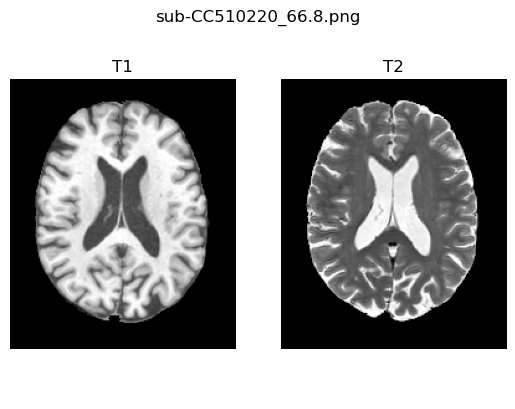

In [165]:
for batch in data_loader:
    if(batch['filename'][0] != 'sub-CC510220_66.8.png'):
        continue
    t1_images = batch['t1'][0]
    t2_images = batch['t2'][0]
    filenames = batch['filename'][0]
    datasets = batch['dataset'][0]
    
    # Stampa le dimensioni dei tensori
    print(f"T1 images shape: {t1_images.shape}")
    print(f"T2 images shape: {t2_images.shape}")
    print(f"Filenames: {filenames}")
    print(f"Datasets: {datasets}")
    
    entry = {'t1': t1_images, 't2': t2_images, 'filename': filenames, 'dataset': datasets}
    # Visualizza la prima immagine del batch
    imshow(entry)
    
    break  # Esci dopo il primo batch per evitare di stampare troppi dati

In [206]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class UnifiedBrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = self._create_file_pairs()
        
    def _create_file_pairs(self):
        pairs = []

        t1_dir = os.path.join(self.root_dir, "t1")
        t2_dir = os.path.join(self.root_dir, "t2")
        
        # Trova i file presenti in entrambe le cartelle
        t1_files = set(os.listdir(t1_dir))
        t2_files = set(os.listdir(t2_dir))
        common_files = t1_files.intersection(t2_files)

        for fname in common_files:
            t1_path = os.path.join(t1_dir, fname)
            t2_path = os.path.join(t2_dir, fname)
            pairs.append((t1_path, t2_path))

        return pairs
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        t1_path, t2_path = self.samples[idx]
        # Carica in bianco e nero
        t1_image = Image.open(t1_path).convert("L")
        t2_image = Image.open(t2_path).convert("L")
        
        if self.transform:
            t1_image = self.transform(t1_image)
            t2_image = self.transform(t2_image)
        
        return {"t1": t1_image, "t2": t2_image, "filename": os.path.basename(t1_path)}

# Esempio di utilizzo
from torchvision import transforms

data_transform = transforms.Compose([
    #  transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

unif_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=data_transform)
print(f"Total pairs: {len(dataset)}")

unif_dataloader = DataLoader(unif_dataset, batch_size=1, shuffle=False)




Total pairs: 2192


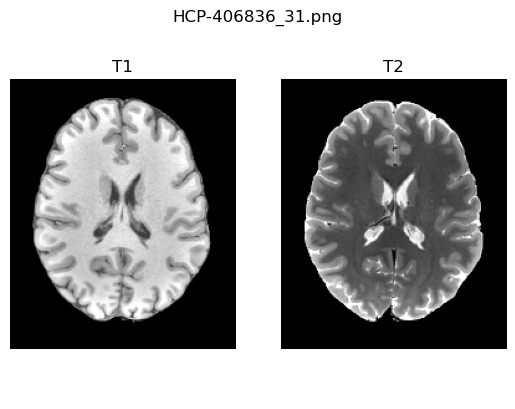

torch.Size([1, 218, 182])
2192


In [210]:
entry = unif_dataset[random.randint(0, len(dataset)-1)]

imshow(entry)
print(entry['t1'].shape)
print(len(unif_dataset))